In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data, summarize_inference_data

In [2]:
Dat = pd.read_csv("../datos/datos_abiertos/base_de_datos.csv.gz",
                  compression='gzip', sep = ",", encoding='iso-8859-1')
Dat.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-07-11,0ca100,2,3,27,2,27,27,4,1,...,2,2,2,2,1,1,99,MÃ©xico,99,97
1,2020-07-11,1cddef,2,3,27,1,27,27,12,1,...,2,1,2,2,1,1,99,MÃ©xico,99,97
2,2020-07-11,108d15,2,3,15,1,9,15,108,1,...,2,2,2,2,2,1,99,MÃ©xico,99,97
3,2020-07-11,0ebb0c,2,4,15,1,9,15,121,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97
4,2020-07-11,1c66ea,2,4,9,2,9,9,6,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97


In [3]:
Dat = Dat[Dat.RESULTADO != 3][['FECHA_SINTOMAS','ENTIDAD_UM', 'ID_REGISTRO', 'RESULTADO']]
Dat

,FECHA_SINTOMAS,ENTIDAD_UM,ID_REGISTRO,RESULTADO
0,2020-05-12,27,0ca100,1
1,2020-06-06,27,1cddef,1
2,2020-06-03,15,108d15,1
3,2020-04-14,15,0ebb0c,1
4,2020-04-22,9,1c66ea,1
...,...,...,...,...
645270,2020-05-02,15,156629,2
645271,2020-05-06,14,1507e5,2
645272,2020-04-19,11,180966,2
645273,2020-04-20,14,1e4757,2


In [4]:
Dat = Dat.groupby(['FECHA_SINTOMAS', 'ENTIDAD_UM', 'RESULTADO']).count()
Dat

ID_REGISTRO
FECHA_SINTOMAS ENTIDAD_UM RESULTADO             
2020-01-01     5          2                    2
               9          2                   10
               14         2                    4
               21         2                    2
               23         2                    1
...                                          ...
2020-07-10     21         1                    3
               22         1                    1
               27         2                    4
               31         1                    2
                          2                    2

[8567 rows x 1 columns]

In [5]:
Dat_ent = Dat.loc[(slice(None), 30), :]
Dat_ent = Dat_ent.droplevel('ENTIDAD_UM')
Dat_ent.reset_index(inplace=True)
Dat_ent = Dat_ent.pivot(index='FECHA_SINTOMAS', columns='RESULTADO', values='ID_REGISTRO')
Dat_ent.reset_index(inplace=True)
Dat_ent.fillna(0, inplace=True)
Dat_ent['total'] = Dat_ent[1] + Dat_ent[2]
Dat_ent = Dat_ent.rename(columns={'FECHA_SINTOMAS': 'date', 1: 'positive', 2: 'negative'}).drop(columns ='negative')
Dat_ent['date'] = pd.to_datetime(Dat_ent.date)
Dat_ent.set_index('date', inplace=True)
Dat_ent

RESULTADO,positive,total
date,,
2020-01-03,0.0,2.0
2020-01-04,0.0,1.0
2020-01-05,0.0,3.0
2020-01-06,0.0,1.0
2020-01-08,0.0,2.0
...,...,...
2020-07-03,103.0,149.0
2020-07-04,79.0,119.0
2020-07-05,36.0,60.0


In [6]:
gm = GenerativeModel('30', Dat_ent)
gm

In [7]:
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 416 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.38421913867467516, but should be close to 0.5. Try to increase the number of tuning steps.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
There were 183 divergences after tuning. Increase `target_accept` or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.29711487116275703, but should be close to 0.5. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [8]:
result = summarize_inference_data(gm.inference_data)
result.tail(10)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-06-28,0.818755,0.790634,0.694012,0.920625,119.896883,144.224968,162.061352,301.0,416.0
2020-06-29,0.808807,0.789153,0.679645,0.936590,115.654279,140.650199,150.286079,259.0,386.0
2020-06-30,0.802320,0.774459,0.658276,0.922007,111.531672,136.861093,155.349977,249.0,359.0
2020-07-01,0.790948,0.750079,0.677106,0.955380,107.460859,132.919871,155.906589,213.0,306.0
2020-07-02,0.782489,0.738069,0.624053,0.932545,103.406080,128.876977,165.097540,143.0,194.0
2020-07-03,0.780700,0.734581,0.605196,0.930069,99.356735,124.768234,154.830762,103.0,149.0
2020-07-04,0.778426,0.737647,0.607176,0.936638,95.331986,120.617609,148.691596,79.0,119.0
2020-07-05,0.777000,0.743183,0.604652,0.948244,91.441775,116.443300,134.387088,36.0,60.0
2020-07-06,0.774468,0.741126,0.591187,0.949193,87.765500,112.270818,57.092554,13.0,18.0


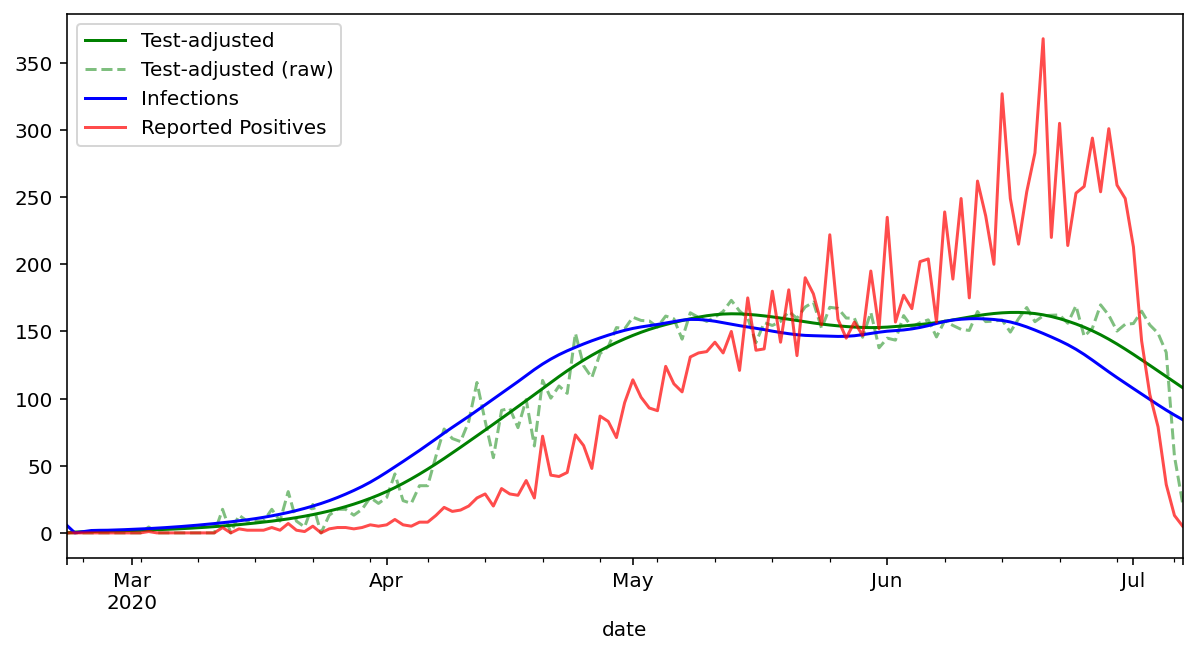

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
result.infections.plot(c="b", label="Infections")
gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
fig.set_facecolor('w')
ax.legend();

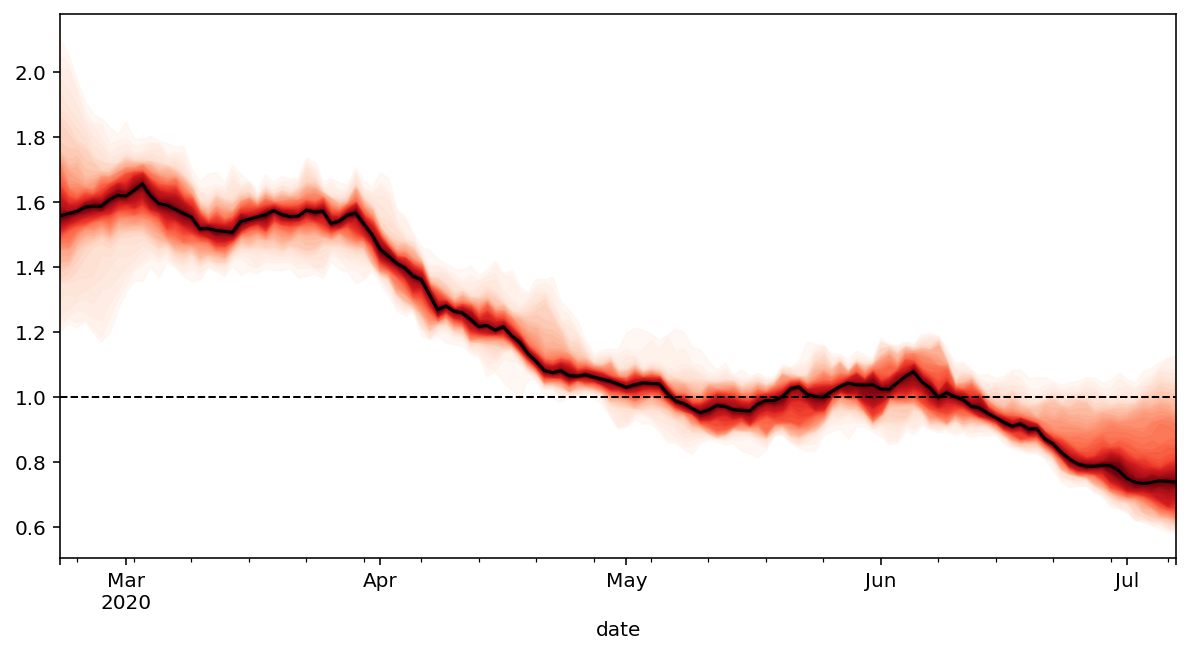

In [11]:
fig, ax = plt.subplots(figsize=(10,5))

# ax.set_title(f"{region} $R_t$")
samples = gm.trace['r_t']
x=result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
fig.set_facecolor('w')

In [ ]:
from scipy import stats as sps
#rgamma(n = 10000, shape = 2.03, rate = 1/2.54)

In [ ]:
sps.gamma?

In [ ]:
np.mean(sps.gamma.rvs(2.03, scale = 2.54, size = 10000))

In [ ]:
    p_delay = sps.gamma.pdf(range(20), 2.03, scale = 2.54)
    p_delay = pd.Series(p_delay)
    p_delay = p_delay / np.sum(p_delay)

In [ ]:
p_delay

In [ ]:
sum(p_delay)